In [ ]:
import numpy as np
import torch 
import cv2
import glob
import os
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd

import cv2
import numpy as np
from skimage.feature import hog
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectPercentile

dim = 100
print(os.listdir("fruits-360_dataset_100x100"))




['fruits-360']


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Modelul rulează pe {device}")

Modelul rulează pe cuda


In [8]:
def getYourFruits(fruits, data_type, print_n=False, k_fold=False):
    images = []
    labels = []
    val = ['Training', 'Test']
    if not k_fold:
        path = "fruits-360_dataset_100x100/fruits-360/"+ data_type + "/"

        for i, f in enumerate(fruits):
            p = f"{path}{f}"
            j=0
            for image_path in glob.glob(os.path.join(p, "*.jpg")):
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.resize(image, (dim, dim))
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                images.append(image)
                labels.append(i)
                j+=1
            if(print_n):
                print("There are " , j , " " , data_type.upper(), " images of " , fruits[i].upper())
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    else:
        for v in val:
            path = "fruits-360_dataset_100x100/fruits-360/" + v + "/"

            for i,f in enumerate(fruits):
                p = path + f
                j=0
                for image_path in glob.glob(os.path.join(p, "*.jpg")):
                    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                    image = cv2.resize(image, (dim, dim))
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    images.append(image)
                    labels.append(i)
                    j+=1
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    
def getAllFruits():
    fruits = []
    for fruit_path in glob.glob("./fruits-360_dataset_100x100/fruits-360/Training/*"):
        fruit = fruit_path.split("/")[-1]
        fruits.append(fruit)
    return fruits

In [ ]:
# fruits = ["Pineapple 1" , "Cocos 1", "Avocado 1"] #Binary classification

fruits = getAllFruits()
X_t, y_train =  getYourFruits(fruits, 'Training', print_n=True, k_fold=False)
X_test, y_test = getYourFruits(fruits, 'Test', print_n=True, k_fold=False)



There are  473   TRAINING  images of  APPLE 6
There are  492   TRAINING  images of  APPLE BRAEBURN 1
There are  444   TRAINING  images of  APPLE CRIMSON SNOW 1
There are  480   TRAINING  images of  APPLE GOLDEN 1
There are  492   TRAINING  images of  APPLE GOLDEN 2
There are  481   TRAINING  images of  APPLE GOLDEN 3
There are  492   TRAINING  images of  APPLE GRANNY SMITH 1
There are  456   TRAINING  images of  APPLE PINK LADY 1
There are  492   TRAINING  images of  APPLE RED 1
There are  492   TRAINING  images of  APPLE RED 2
There are  429   TRAINING  images of  APPLE RED 3
There are  490   TRAINING  images of  APPLE RED DELICIOUS 1
There are  492   TRAINING  images of  APPLE RED YELLOW 1
There are  672   TRAINING  images of  APPLE RED YELLOW 2
There are  702   TRAINING  images of  APPLE HIT 1
There are  492   TRAINING  images of  APRICOT 1
There are  427   TRAINING  images of  AVOCADO 1
There are  491   TRAINING  images of  AVOCADO RIPE 1
There are  490   TRAINING  images of  BANAN

In [ ]:
def preprocess_images(images, target_size=(32, 32)):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, target_size)
        resized_images.append(resized_img)
        
    return np.array(resized_images)

def extract_features_orb(images, max_keypoints=300, edge_threshold=6):
    orb = cv2.ORB_create(nfeatures=max_keypoints, edgeThreshold=edge_threshold, patchSize=4)
    descriptors_list = []

    for img in images:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = orb.detectAndCompute(gray_img, None)
        if descriptors is not None:
            descriptors_list.append(descriptors)
        else:
            descriptors_list.append(np.zeros((0, 32)))
    
    return descriptors_list

def reduce_dimensionality(features, n_components=20):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    pca = PCA(n_components=n_components, random_state=42)
    reduced_features = pca.fit_transform(scaled_features)
    
    return reduced_features, scaler, pca

def generate_histograms(descriptors_list, kmeans, pca=None):
    histograms = []
    for descriptors in descriptors_list:
        if descriptors is not None and len(descriptors) > 0:
            if pca is not None:
                descriptors = pca.transform(descriptors)  
            cluster_assignments = kmeans.predict(descriptors)  
            histogram, _ = np.histogram(cluster_assignments, bins=np.arange(kmeans.n_clusters + 1))
        else:
            histogram = np.zeros(kmeans.n_clusters)
        histograms.append(histogram)
        
    return np.vstack(histograms)

def feature_selection(features, method='variance', percentile=10):
    if method == 'variance':
        selector = VarianceThreshold(threshold=0.01) 
    elif method == 'percentile':
        selector = SelectPercentile(percentile=percentile)
    else:
        raise ValueError("Metoda de selecție trebuie să fie 'variance' sau 'percentile'.")
    
    selected_features = selector.fit_transform(features)
    
    return selected_features, selector

def bag_of_words(descriptors, k, random_state=42):
    all_descriptors = np.vstack([desc for desc in descriptors if desc.shape[0] > 0])
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    kmeans.fit(all_descriptors)
    
    return kmeans


# Redimensionăm imaginile
X_t_resized = preprocess_images(X_t, target_size=(32, 32))
X_test_resized = preprocess_images(X_test, target_size=(32, 32))

# Extragem descriptorii ORB
train_descriptors = extract_features_orb(X_t_resized)
test_descriptors = extract_features_orb(X_test_resized)

# Aplicăm KMeans pe descriptorii ORB
n_clusters = 100
kmeans = bag_of_words(train_descriptors, k=n_clusters)

# Generăm histogramele pe baza cluster-urilor KMeans
X_train_histograms = generate_histograms(train_descriptors, kmeans, pca=None)
X_test_histograms = generate_histograms(test_descriptors, kmeans, pca=None)

# Standardizarea și reducerea dimensionalității
X_train_scaled, scaler, pca = reduce_dimensionality(X_train_histograms, n_components=20)
X_test_scaled = pca.transform(scaler.transform(X_test_histograms))

# Selecția atributelor
X_train_selected, selector = feature_selection(X_train_scaled, method='variance', percentile=10)
X_test_selected = selector.transform(X_test_scaled)

# Afișăm dimensiunile seturilor finale
print(f"Dimensiunea setului de antrenament: {X_train_selected.shape}")
print(f"Dimensiunea setului de test: {X_test_selected.shape}")


Dimensiunea setului de antrenament: (70491, 20)
Dimensiunea setului de test: (23619, 20)


### Distributia claselor

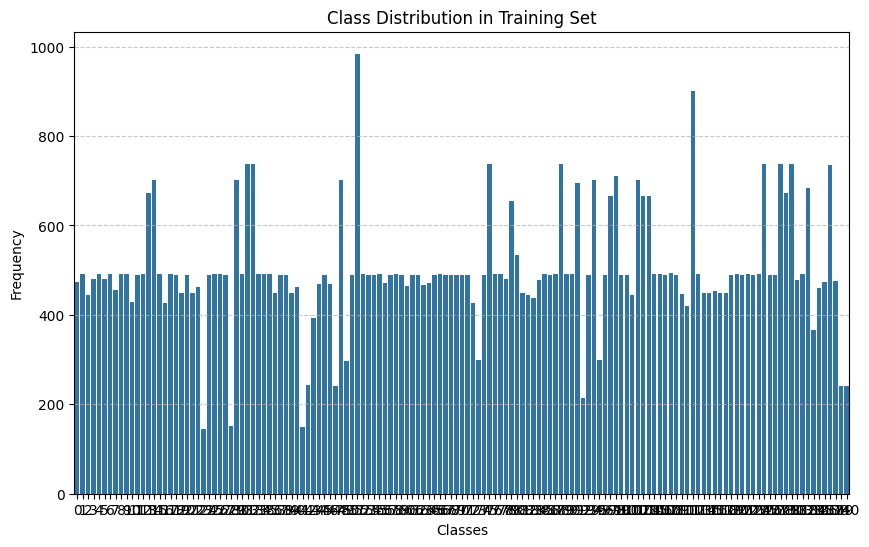

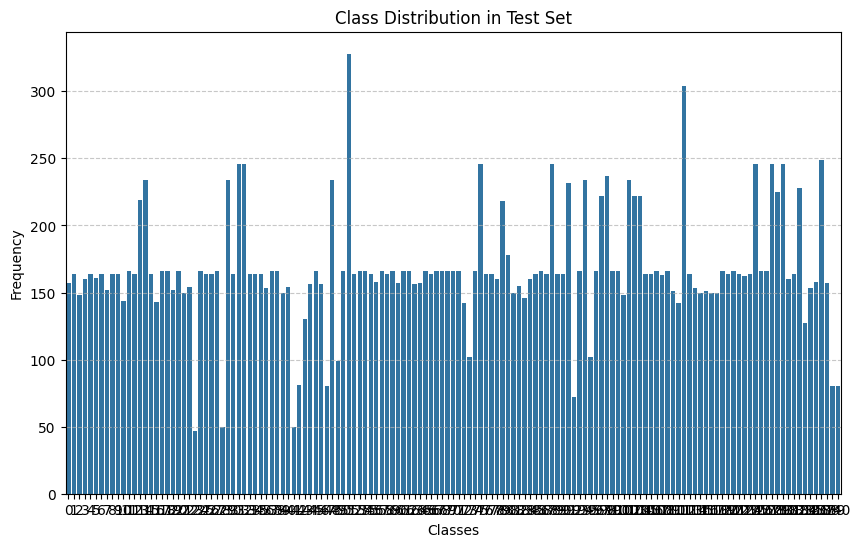

In [ ]:
def plot_class_distribution(labels, title):
    label_counts = pd.Series(labels).value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=label_counts.index, y=label_counts.values)
    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Frequency")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

plot_class_distribution(y_train, "Class Distribution in Training Set")
plot_class_distribution(y_test, "Class Distribution in Test Set")


###  Varianta cumulativa explicata de componentele principale (PCA).

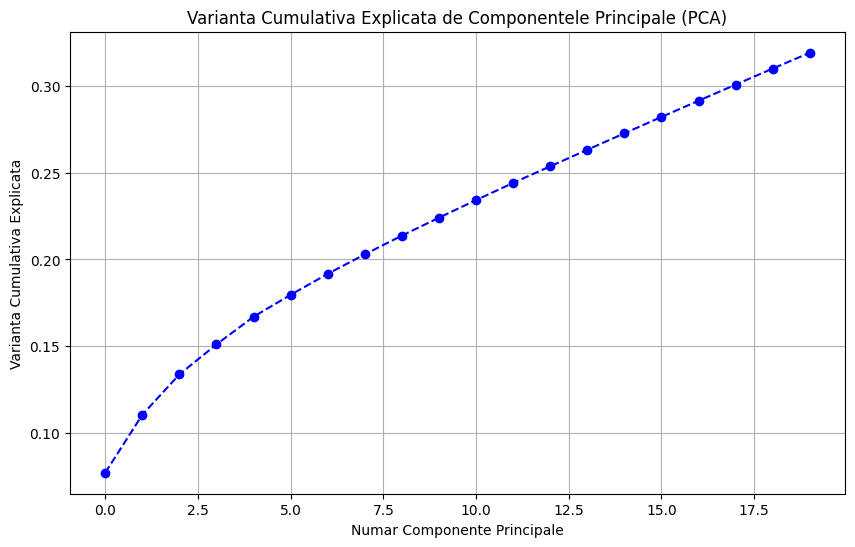

In [37]:
explained_variance_ratio = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.title('Varianta Cumulativa Explicata de Componentele Principale (PCA)')
plt.xlabel('Numar Componente Principale')
plt.ylabel('Varianta Cumulativa Explicata')
plt.grid(True)
plt.show()


### Cantitatea de variabilitate explicata de PCA

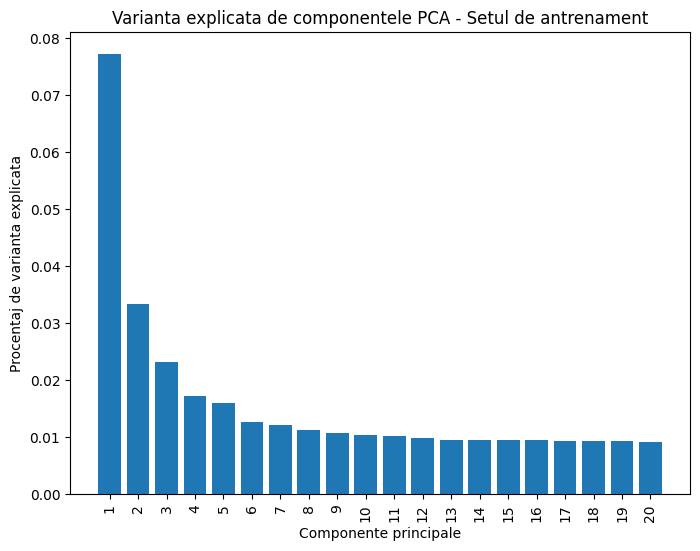

In [36]:
def plot_pca_variance_explained(pca, title="Varianta explicata de componentele PCA"):
    explained_variance = pca.explained_variance_ratio_

    plt.figure(figsize=(8, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, tick_label=range(1, len(explained_variance) + 1))
    plt.xlabel('Componente principale')
    plt.ylabel('Procentaj de varianta explicata')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

plot_pca_variance_explained(pca, title="Varianta explicata de componentele PCA - Setul de antrenament")


### Vizualizarea punctelor cheie identificate în imagini prin suprapunerea lor peste imaginea originală

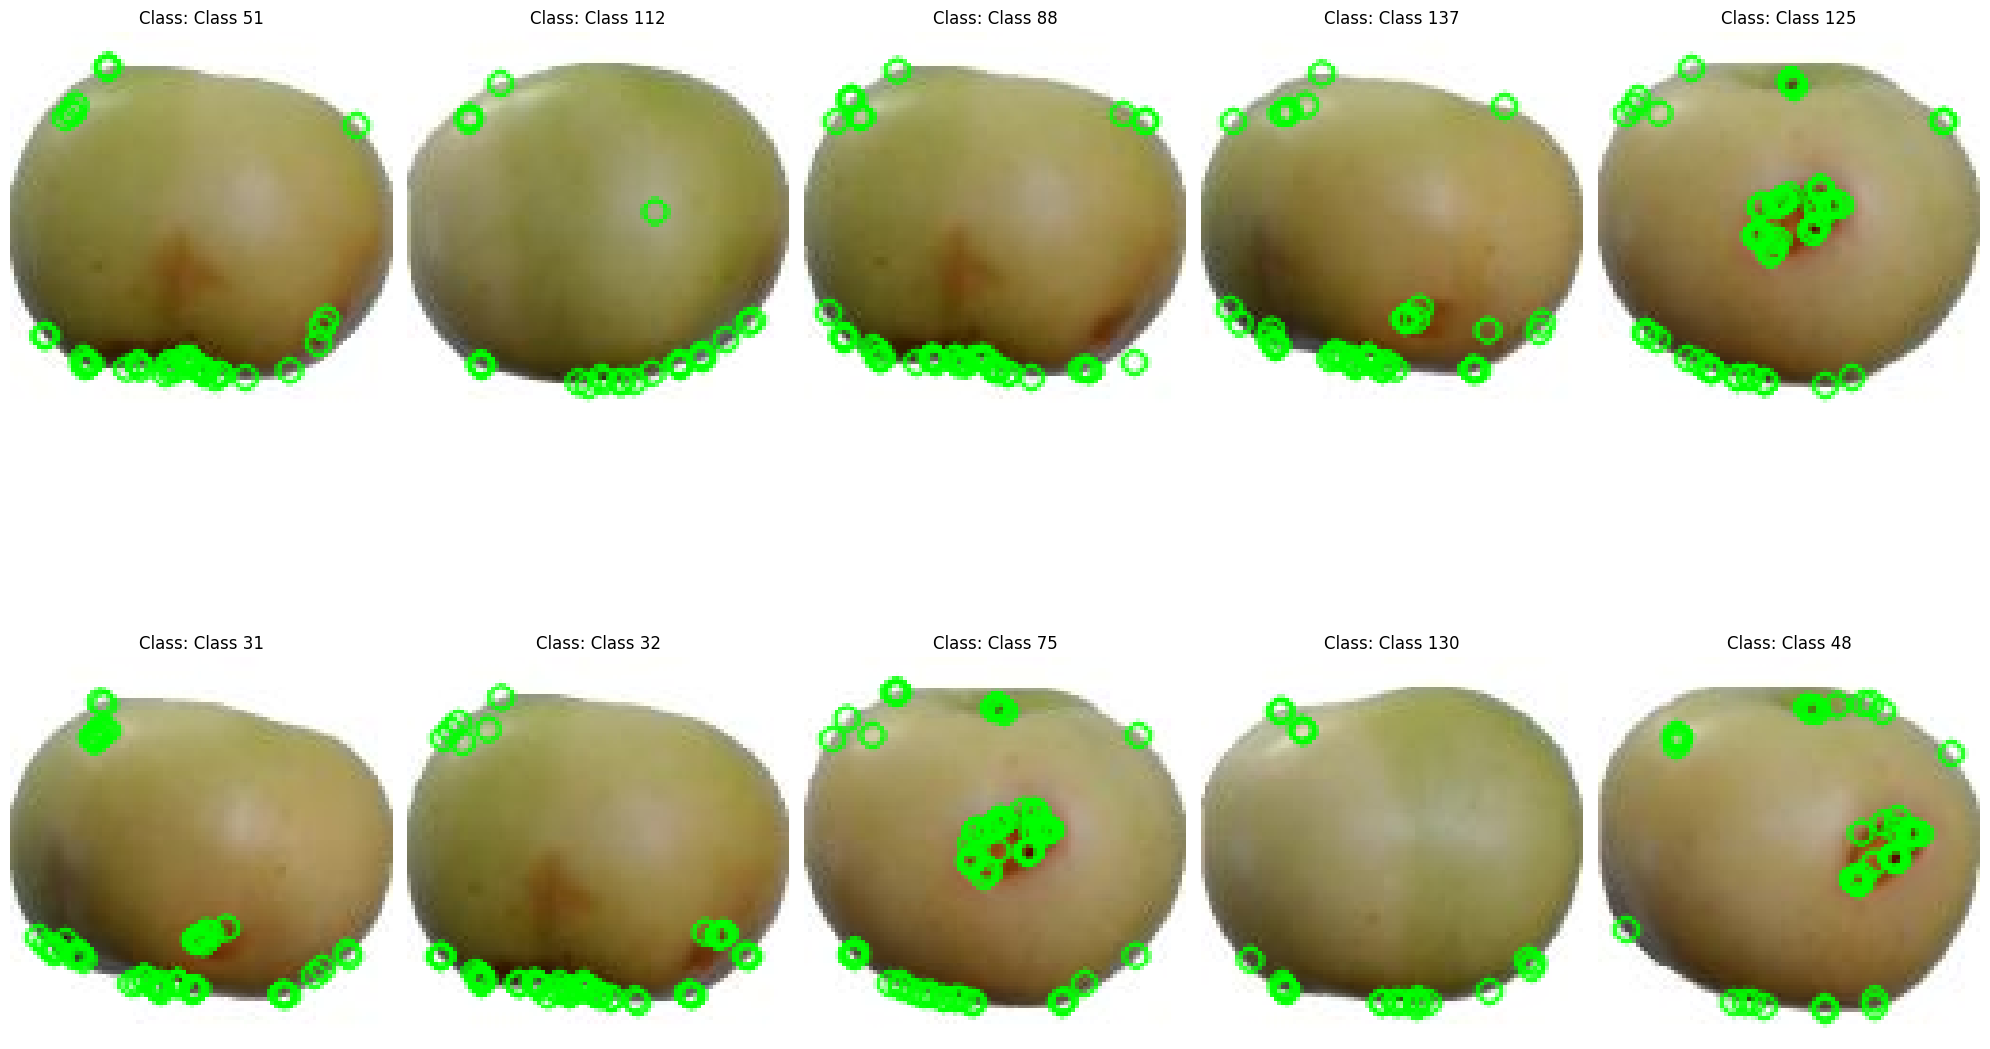

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

unique, counts = np.unique(y_train, return_counts=True)
class_frequencies = dict(zip(unique, counts))

sorted_classes = sorted(class_frequencies.items(), key=lambda x: x[1], reverse=True)

top_10_classes = [class_ for class_, _ in sorted_classes[:10]]


def display_orb_keypoints(images, labels, class_names, n=1):
    orb = cv2.ORB_create(nfeatures=300, scaleFactor=1.2, edgeThreshold=6, patchSize=4)
    
    plt.figure(figsize=(20, 15))
    for i in range(n):
        kp, _ = orb.detectAndCompute(images[i], None)
    
        image_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        image_with_keypoints = cv2.drawKeypoints(image_rgb, kp, None, color=(0, 255, 0))
        image_with_keypoints = cv2.cvtColor(image_with_keypoints, cv2.COLOR_RGB2BGR)
        
        plt.subplot(2, 5, i+1)  
        plt.imshow(image_with_keypoints)
        
       
        class_label = labels[i]
        class_name = class_names[class_label]  
        plt.title(f"Class: {class_name}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def select_one_image_from_each_class(images, labels, top_classes):
    selected_images = []
    selected_labels = []
    
    for class_id in top_classes:
        class_indices = np.where(labels == class_id)[0]
        if len(class_indices) > 0:
            selected_images.append(images[class_indices[0]])  
            selected_labels.append(class_id)  
    
    return selected_images, selected_labels

selected_images, selected_labels = select_one_image_from_each_class(X_t, y_train, top_10_classes)

display_orb_keypoints(selected_images, selected_labels, class_names, n=len(selected_images))



In [ ]:
import cv2
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectPercentile
import xgboost as xgb
from skimage.feature import hog
import matplotlib.pyplot as plt
import pandas as pd


log_reg = LogisticRegression(max_iter=5000)
log_reg_params = {'C': [0.1, 1, 10], 'multi_class': ['ovr', 'multinomial']}
log_reg_search = RandomizedSearchCV(log_reg, log_reg_params, cv=5)
log_reg_search.fit(X_train_selected, y_train)



/home/regelepirat/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=LogisticRegression(max_iter=5000),
                   param_distributions={'C': [0.1, 1, 10],
                                        'multi_class': ['ovr', 'multinomial']})

In [20]:
# # SVM
# svm = SVC()
# svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly']}
# svm_search = RandomizedSearchCV(svm, svm_params, cv=5)
# svm_search.fit(X_train_selected, y_train)



In [ ]:
# # Random Forest
# rf = RandomForestClassifier()
# rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20], 'max_features': ['sqrt', 'log2']}
# rf_search = RandomizedSearchCV(rf, rf_params, cv=5)
# rf_search.fit(X_train_selected, y_train)


In [ ]:
# # XGBoost
# xgb_model = xgb.XGBClassifier()
# xgb_params = {'n_estimators': [100, 200], 'max_depth': [10, 20], 'learning_rate': [0.01, 0.1]}
# xgb_search = RandomizedSearchCV(xgb_model, xgb_params, cv=5)
# xgb_search.fit(X_train_selected, y_train)

In [44]:
# --- Evaluarea performanței ---
models = [log_reg_search]
# , svm_search, rf_search, xgb_search]
model_names = ['Logistic Regression']
# , 'SVM', 'Random Forest', 'XGBoost']

results_list = []

for model_name, model in zip(model_names, models):
    y_pred = model.predict(X_train_selected)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
    
    accuracy_mean = np.mean(accuracy)
    accuracy_variance = np.var(accuracy)
    
    precision_mean = np.mean(precision)
    precision_variance = np.var(precision)
    
    recall_mean = np.mean(recall)
    recall_variance = np.var(recall)
    
    f1_mean = np.mean(f1)
    f1_variance = np.var(f1)
    
    results_list.append({
        "Model": model_name,
        "Params": model.best_params_,
        "Accuracy_Mean": f"{accuracy_mean:.3f}",
        "Precision_Mean": f"{precision_mean:.3f}",
        "Recall_Mean": f"{recall_mean:.3f}",
        "F1_Mean": f"{f1_mean:.3f}",
        "Accuracy_Variance": f"{accuracy_variance:.3f}",
        "Precision_Variance": f"{precision_variance:.3f}",
        "Recall_Variance": f"{recall_variance:.3f}",
        "F1_Variance": f"{f1_variance:.3f}"
    })
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

results = pd.DataFrame(results_list)

print(results)

ValueError: Found input variables with inconsistent numbers of samples: [21148, 70491]